In [15]:
# Assignment 1

import pandas as pd
import time

bgdata = pd.read_json('band_gap_data.json')

# boolean mask
start = time.time()

mask = (
    (bgdata['temperature_K'] > 300) &
    (bgdata['crystallinity'] == "Polycrystalline") &
    (bgdata['exp_method'] == "Reflection")
)
filtered_df = bgdata[mask]

end = time.time()

print(f"Duration of boolean mask: {round(end - start, 4)} seconds")

# for-loop, utilizing iat
start = time.time()

temp_col = bgdata.columns.get_loc("temperature_K")
crys_col = bgdata.columns.get_loc("crystallinity")
exp_col = bgdata.columns.get_loc("exp_method")

filtered_rows = []
for i in range(len(bgdata)):
    if (bgdata.iat[i, temp_col] > 300 and
        bgdata.iat[i, crys_col] == "Polycrystalline" and
        bgdata.iat[i, exp_col] == "Reflection"):
        filtered_rows.append(bgdata.iloc[i])

end = time.time()

print(f"Duration of for-loop, utilizing iat: {round(end - start, 4)} seconds")

# for-loop, utilizing iloc

start = time.time()

filtered_rows_iloc = []
for i in range(len(bgdata)):
    if (bgdata.iloc[i]['temperature_K'] > 300 and
        bgdata.iloc[i]['crystallinity'] == "Polycrystalline" and
        bgdata.iloc[i]['exp_method'] == "Reflection"):
        filtered_rows_iloc.append(bgdata.iloc[i])

end = time.time()

print(f"Duration of for-loop, utilizing iloc: {round(end - start, 4)} seconds")


Duration of boolean mask: 0.0029 seconds
Duration of for-loop, utilizing iat: 0.0091 seconds
Duration of for-loop, utilizing iloc: 0.0176 seconds


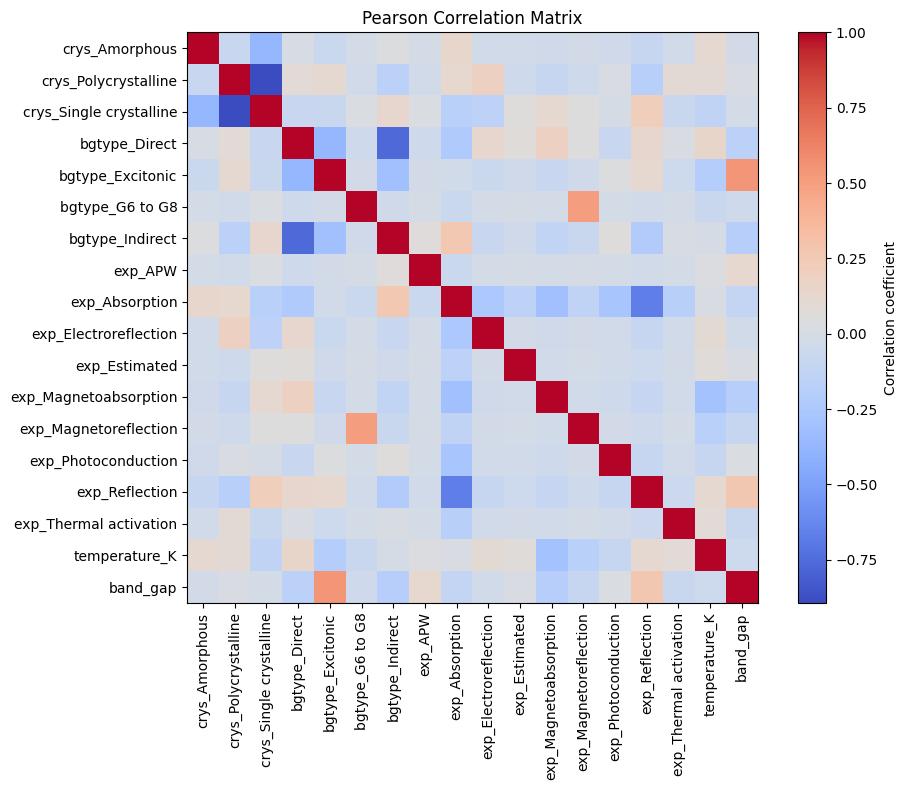

alpha=0.01: Train MSE=3.4787, Test MSE=3.0094
alpha=0.1: Train MSE=3.4797, Test MSE=3.0111
alpha=1: Train MSE=3.5128, Test MSE=3.0223
alpha=5: Train MSE=3.6060, Test MSE=3.0103
alpha=10: Train MSE=3.6809, Test MSE=2.9669
alpha=100: Train MSE=4.8473, Test MSE=2.5756


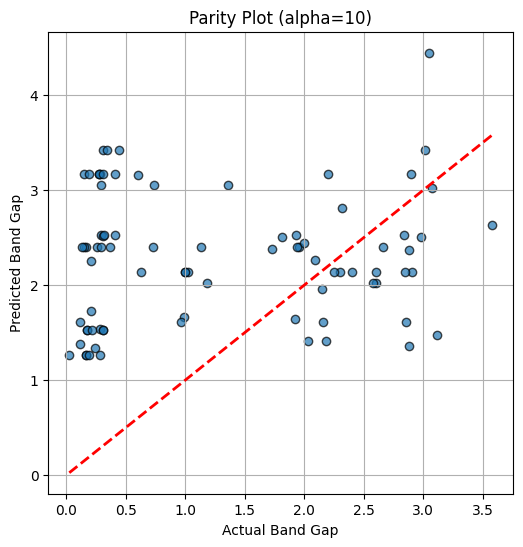

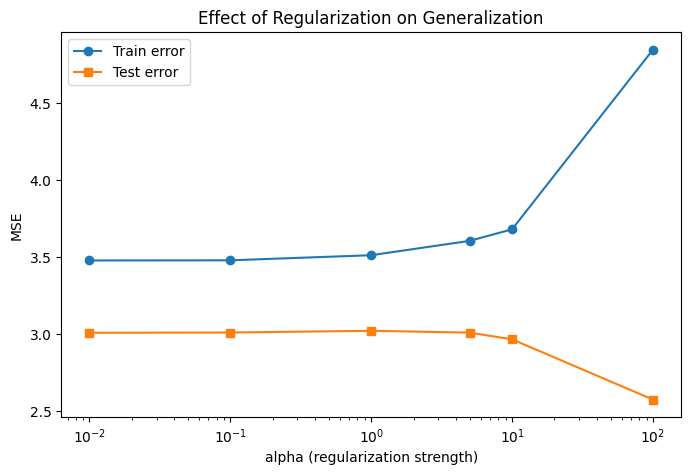

In [ ]:
# Assignment 2

import matplotlib.pyplot as plt
import numpy as np

# 1. Remove missing data for the relevant columns:
bgdata = bgdata.dropna(subset=['crystallinity', 'band_gap_type', 'exp_method', 'temperature_K', 'band_gap'])

# 2. Remove all other columns except the ones specified in step 1.
bgdata = bgdata.drop(columns=[col for col in bgdata.columns if col not in ['crystallinity', 'band_gap_type', 'exp_method', 'temperature_K', 'band_gap']])

# 3. Create one-hot features (that's a way of representing categorical variables as numerical vectors) for columns 'crystallinity', 'band_gap_type', and 'exp_method'
crys_dummies = pd.get_dummies(bgdata['crystallinity'], prefix='crys')
bgtype_dummies = pd.get_dummies(bgdata['band_gap_type'], prefix='bgtype')
exp_dummies = pd.get_dummies(bgdata['exp_method'], prefix='exp')

# 4. Plot the Pearson correlation matrix for all features (i.e., the ones created in step 3, plus temperature_K) and the target label band_gap
features = pd.concat([
    crys_dummies,
    bgtype_dummies,
    exp_dummies,
    bgdata[['temperature_K', 'band_gap']]
], axis=1)

corr = features.corr(method='pearson')

plt.figure(figsize=(10,8))
plt.imshow(corr, cmap='coolwarm', interpolation='nearest')
plt.colorbar(label='Correlation coefficient')
plt.xticks(ticks=np.arange(len(corr.columns)), labels=corr.columns, rotation=90)
plt.yticks(ticks=np.arange(len(corr.index)), labels=corr.index)
plt.title("Pearson Correlation Matrix")
plt.tight_layout()
plt.show()

# The different crystallinity values are negatively correlated with one another, which makes sense because one cannot exist at the same time as another. There does not seem to be a correlation with the target label band_gap
# Excitonic band gap types seem to be positively correlated with the target value band_gap, which would indicate that their band gaps tend to be larger. The opposite is true for indirect and direct band gap types, which are negatively correlated
# The experiment methods and temperature seem to be weakly correlated with the target value band_gap

# 5. Now split the dataset into train and test sets (e.g., 80/20)
X = features.drop(columns=['band_gap']).astype(float).values # convert all features to float
y = features['band_gap'].astype(float).values

split = int(0.8 * len(features))
X_train, y_train = X[:split], y[:split]
X_test, y_test = X[split:], y[split:]

# 6. Loop through different regularization strengths alpha and train ridge regression on the training set. Log both the training set and test set mean squared errors (MSEs) in a list
X = features.drop(columns=['band_gap']).values # separate features and target
y = features['band_gap'].values

X_train = np.c_[np.ones(X_train.shape[0]), X_train] # add bias column
X_test = np.c_[np.ones(X_test.shape[0]), X_test]

alphas = [1e-2, 1e-1, 1, 5, 10, 100]
results = []

for alpha in alphas:
    I = np.eye(X_train.shape[1]) # bias term
    I[0,0]=0 # don't penalize bias term
    beta = np.linalg.inv(X_train.T @ X_train + alpha * np.eye(X_train.shape[1])) @ X_train.T @ y_train
     
    y_train_pred = X_train @ beta
    y_test_pred = X_test @ beta

    train_mse = np.mean((y_train - y_train_pred)**2)
    test_mse = np.mean((y_test - y_test_pred)**2)

    results.append((alpha, train_mse, test_mse))
    print(f"alpha={alpha}: Train MSE={train_mse:.4f}, Test MSE={test_mse:.4f}")

# 7. Finally, create a parity plot for the optimal alpha (true vs. predicted band_gap). Also create a MSE vs. alpha plot for the training and test set errors

optimal_alpha = 10 # 100 has the lowest test MSE, but the train MSE is very high

I = np.eye(X_train.shape[1])
I[0,0]=0
beta_optimal = np.linalg.inv(X_train.T @ X_train + optimal_alpha * np.eye(X_train.shape[1])) @ X_train.T @ y_train

y_test_pred_optimal = X_test @ beta_optimal

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_test_pred, alpha=0.7, edgecolor="k")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # y=x line

plt.xlabel("Actual Band Gap")
plt.ylabel("Predicted Band Gap")
plt.title(f"Parity Plot (alpha={optimal_alpha})")
plt.grid(True)
plt.savefig("parity_plot.png", dpi=300, bbox_inches="tight")
plt.show()

alphas = [r[0] for r in results] # to extract the lists from the results
train_mses = [r[1] for r in results]
test_mses = [r[2] for r in results]

plt.figure(figsize=(8, 5))
plt.semilogx(alphas, train_mses, marker="o", label="Train error")
plt.semilogx(alphas, test_mses, marker="s", label="Test error")
plt.xlabel("alpha (regularization strength)")
plt.ylabel("MSE")
plt.title("Effect of Regularization on Generalization")
plt.legend()
plt.savefig("ridge_mse_plot.png", dpi=300, bbox_inches="tight")
plt.show()

# 8. Based on these plots and metrics, how well does ridge regression perform and what may be a bottleneck here?
# Ridge regression does not perform very well on this dataset, there are high MSE values for both the training and test sets. 
# The parity plot shows deviation from the ideal y=x line, which would indicate that the model's predictions are not very accurate. 
# The bottleneck here may be the potential complexity of the relationship between the features and the target variable that ridge regression may not be able to capture effectively due to its linear nature.
    

In [ ]:
# Assignment 3

# Ch 5: Linear Regression
## 5.6: Multi-Output Regression
# Multi-output regression is a form of linear regression where both the input and output are vector-valued
# Typically (for traditional linear regression) the input (x) is an n-dimensional vector and the output (y) is scalar
# Deriving the cost function for multi-output regression almost exactly mirrors the scalar-output case
# There is a least squares and least absolute deviation cost
# For Python implemenation, the same linear model from the scalar-output can be used
# We use variables to denote bias and feature-touching weights
# Cost for multi-output regression takes in a matrix of parameters

# Ch 6: Linear Two-Class Classification
## 6.5: Support Vector Machines
# We assume that data is perfectly linearly separable
# The learned decision boundary doesn't differ greatly from logistic regression/Perceptron when data is realistic (not perfectly separable)
# Margin-Perceptron cost is very similar to the original Perceptron cost, but a one is added to the nonzero input which prevents the issue of a trivial zero solution
# Softmax smoothes out the Margin-Perceptron
# Perfectly linearly separable data has an infinite number of hyperplanes that could divide it
# We can judge their quality by their margin lengths
# Larger margin length = better hyperplane 
# This is equivalent to finding the one with the smallest possible normal vector
# Hard-margin SVM guarantees the hyperplane will separate data perfectly
# We can form an unconstrained formulation of the problem by relaxing constraints- regularization approach (soft-margin SVM cost)
# Soft-margin SVM allows us to deal with noisy data- impossible in hard-margin problem
## 6.6: Which Approach Produces the Best Results?
# If we forgo the assumption of perfectly separable data, the soft-margin problem often returns the exact same solution as Perceptron or logistic regression
## 6.7: The Categorical Cross Entropy Cost
# Employ categorical labels instead of numerical ones
# Categorical cross entropy cost function is equivalent to cross entropy cost
# This is a special case of multi-ouput regression
## 6.8: Classification Quality Metrics
# Predictions can be made using a trained model
# Once a proper decision boundary is learned, its confidence can be judged in any point based on the point's distance to the decision boundary
# We have zero confidence in points lying along the boundary, little confidence in points near the boundary, and high confidence in points far from the boundary
# We can determine a confidence value that is often interpreted as a probability
# You can judge the quality of a fully trained model by counting the number of misclassifications it forms over our training dataset
# Can also compute accuracy- the percentage of training dataset whose labels are correclty predicted by the model
# If a dataset contains highly imbalanced classes, a balanced/weighted accuracy metric is necessary
# A confusion matrix is an additional metric for judging the quality of a trained model for two-class classification
## 6.9: Weighted Two-Class Classification
# We can implement a weighted classification by weighting individual points to emphasize or deemphasize their importance
# We can assign fixed weight values based on our "confidence" of the legitimacy of a data point
# This is typically used to deal with imbalanced datasets

# Ch 7: Linear Multi-Class Classification
## 7.3: Multi-Class Classification and the Perceptron 
# All C classifiers are simultaneously trained to directly satisfy the fusion rule
# The fusion rule defines class ownership for every point x in the input space of the problem
# Multi-class Perceptron cost can be thought of as a direct generalization of the two-class Perceptron
# Ideally, all training data points should have a distance from its class decision boundary greater than or equal to the distance to every other two-class decision boundary
# The cost function is convex and has a trivial minimum at zero
# Multi-Class Softmax (smoothed version) replaces the non-smooth max in the Perceptron cost with a Softmax function to make it differentiable
# Is convex, smooth, and has no trivial zero solution
# It is equivalent to the Cross-Entropy loss used in modern machine learning
# When implementing with Python, use NumPy for efficiency
## 7.4: Which Approach Produces the Best Results?
# Multi-Class Perceptron/Softmax improves over OvA by training all classes jointly, not separately

# Ch 9: Feature Engineering and Selection
# Feature engineering improves data quality by transforming features for better model performance
# Mean-centering subtracts the mean of each feature to center data around zero
# Standard scaling divides by the standard deviation so all features have unit variance
# PCA rotation decorrelates features and aligns them with principal components
# PCA sphering (whitening) combines centering, rotation, and variance normalization for zero-mean, unit-variance, uncorrelated data
# Feature selection identifies the most relevant inputs
# Boosting is fast and simple, adds features that most reduce the model's error
# Regulzarization is more comprehensive, starts with all features and penalizes large weights
# Feature engineering prepares data for learning, feature selection simplifies models and highlights important predictors




